In [1]:
#import required libraries
from utils import aws # used to create aws session and load parquet 
import pandas as pd
import numpy as np
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
import math
import matplotlib.pyplot as plt

In [2]:
# Define trading strategy based on model predictions and trading parameters
def simple_trading_strategy(prediction, current_mid_price):
    if prediction > current_mid_price:
        return 'buy'  # Buy if the mid-price prediction is positive
    elif prediction < current_mid_price:
        return 'sell'  # Sell if the mid-price prediction is negative
    else:
        return 'hold'  # Hold if the mid-price prediction is neutral

In [59]:
# Implement trading simulator
class TradingSimulator:
    def __init__(self, historical_data, prediction_model, trading_strategy, initial_cash, split_limit, feature_columns, prediction_type):
        """
        Initialize the TradingSimulator object with historical data, prediction model,
        trading strategy, and initial cash.

        Parameters:
        - historical_data: DataFrame containing historical market data
        - prediction_model: Model used to generate predictions
        - trading_strategy: Function defining the trading strategy
        - initial_cash: Initial cash available for trading
        - feature_columns: List of column headers used as features for the prediction
        - prediction_type: String that is either 'xgb' or 'normal' to define the prediction method used, 'normal' is the default
        """
        self.historical_data = historical_data
        self.prediction_model = prediction_model
        self.trading_strategy = trading_strategy
        self.feature_columns = feature_columns
        self.prediction_type = prediction_type
        self.split_limit = split_limit
        self.portfolio = 0  # Initial portfolio value
        self.cash = initial_cash  # Initial cash
        self.profit_loss = []  # Store profit/loss at each time step
        self.trades = [] # Store trade history
        
    def run_prediction(self, features):
        """
        Use prediction model to generate predictions

        This method checks the prediction_type and calls the prediction_model predict function.
        
        Arguments:
        - features: A row of the dataframe with the values for the features used in model training
        """
        # 
        if self.prediction_type == 'xgb':
            features_df = pd.DataFrame(features).T
            features_df = features_df.apply(pd.to_numeric)
            # Convert features to DMatrix
            features_dmatrix = xgb.DMatrix(features_df)
            prediction = self.prediction_model.predict(features_dmatrix)
        elif self.prediction_type == 'lstm':
            features_df = pd.DataFrame(features).T
            features_df = features_df.astype(float)
            input_tensor = torch.tensor(features_df.values.reshape(1, 1, -1), dtype=torch.float32)
            with torch.no_grad():
                prediction_tensor = self.prediction_model(input_tensor)
                prediction = prediction_tensor.item()
        else:
            prediction = self.prediction_model.predict([features])[0]
        return prediction

    def run_simulation(self):
        """
        Run the trading simulation.

        This method iterates over historical data, generates predictions,
        applies trading strategy, and executes trades accordingly.
        """
        for index, row in self.historical_data.iterrows():
            # Extract features from historical data for prediction
            features = row[self.feature_columns]
            # Use prediction model to generate predictions
            prediction = self.run_prediction(features)

            # Get the current mid-price (replace 'current_mid_price' with the actual value)
            current_mid_price = row['Mid_Price_EMA_Short_z-score_normalised'] #TODO Replace with target

            # Implement trading strategy within the simulator
            trade_action = self.trading_strategy(prediction, current_mid_price)

            # if Bid-Ask Split is less than the split-limit
            if self.split_limit >= row['Ask'][0][0] - row['Bid'][0][0]:
            
                # Execute trade based on prediction
                # If the timestamp is outside the first 15 or last 30 minutes
                if row['Timestamp'] >= 90 and row['Timestamp'] < 28800:

                    if trade_action == 'buy':
                        
                        if self.cash > 0:
                            # Invest all available cash in buying assets from level one in the orderbook
                            trade_price = row['Ask'][0][0] # lowest (level one) ask-price
                            max_quantity = math.floor(self.cash / trade_price) # max quantity of shares the model can afford to buy (must be an integer)
                            quantity_available = row['Ask'][0][1] # actual quantity of the lowest (level one) ask-price

                            if max_quantity < quantity_available:
                                # if the maximum number the model can afford is less than the quantity available buy the max it can afford 
                                quantity_to_buy = max_quantity
                            else:
                                # if the maximum number the model can afford is more than the quantity available buy the quantity available
                                quantity_to_buy = quantity_available

                            if quantity_to_buy > 0:
                                if index == 0:
                                    # If it's the first row of historical data
                                    # Buy action
                                    self.portfolio += quantity_to_buy # Increase portfolio by bought quantity
                                    self.cash = self.cash - (quantity_to_buy * trade_price) # Decrease cash by spent amount
                                    # Record the trade in the trades list
                                    self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'buy', trade_price, quantity_to_buy, self.cash, self.portfolio, prediction, current_mid_price])
                                elif index > 0 and index - 1 < len(self.historical_data):
                                    # If it's not the first row and there is more historical data
                                    # Check if the trade price and quantity available are different from the previous row
                                    if (trade_price != self.historical_data.iloc[index - 1]['Ask'][0][0] and quantity_available != self.historical_data.iloc[index - 1]['Ask'][0][1]):
                                        # Buy action
                                        self.portfolio += quantity_to_buy # Increase portfolio by bought quantity
                                        self.cash = self.cash - (quantity_to_buy * trade_price) # Decrease cash by spent amount
                                        # Record the trade in the trades list
                                        self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'buy', trade_price, quantity_to_buy, self.cash, self.portfolio, prediction, current_mid_price])
                                    else: 
                                        # Hold action if conditions are not met -- This prevents repeating the same trade over and over as the order book is not updated
                                        self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                                else:
                                    # Hold action if index is out of range
                                    self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                            else:
                                # Hold if not enough cash available to fullfil the buy action
                                self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                        else:
                            # Hold if no available cash
                            self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                            
                        
                    elif trade_action == 'sell':
                        
                        if self.portfolio > 0:
                            # Invest all available shares to level one bid in the orderbook
                            trade_price = row['Bid'][0][0] # highest (level one) bid-price
                            quantity_available = row['Bid'][0][1] # actual quantity of the highest (level one) bid-price
                            max_quantity = self.portfolio # max quantity of shares the model has to sell (must be an integer)

                            if max_quantity < quantity_available:
                                # if the maximum number the model can sell is less than the quantity available sell the max it can
                                quantity_to_sell = max_quantity
                            else:
                                # if the maximum number the model can sell is more than the quantity available sell the quantity available
                                quantity_to_sell = quantity_available
                            
                            if index == 0:
                                # If it's the first row of historical data
                                # Sell action
                                self.portfolio -= quantity_to_sell # Decrease portfolio by sold quantity
                                self.cash += quantity_to_sell * trade_price  # Increase cash by earned amount
                                # Record the trade in the trades list
                                self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'sell', trade_price, quantity_to_sell, self.cash, self.portfolio, prediction, current_mid_price])
                            elif index > 0 and index - 1 < len(self.historical_data):
                                # If it's not the first row and there is more historical data
                                # Check if the trade price and quantity available are different from the previous row
                                if (trade_price != self.historical_data.iloc[index - 1]['Bid'][0][0] and quantity_available != self.historical_data.iloc[index - 1]['Bid'][0][1]):
                                    # Sell action
                                    self.portfolio -= quantity_to_sell # Decrease portfolio by sold quantity
                                    self.cash += quantity_to_sell * trade_price # Increase cash by earned amount
                                    # Record the trade in the trades list
                                    self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'sell', trade_price, quantity_to_sell, self.cash, self.portfolio, prediction, current_mid_price])
                                else: 
                                    # Hold action if conditions are not met -- This prevents repeating the same trade over and over as the order book is not updated
                                    self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                            else: 
                                # Hold action if index is out of range    
                                self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])

                        else:
                            # Hold if no assets to sell
                            self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                            
                    else:
                        # Hold if not a buy or sell signal
                        self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                    
                # If the timestamp is between the last 30 mins and the last 15 minutes sell regardless of trade action, this is to close position.
                elif row['Timestamp'] >= 28800 and row['Timestamp'] < 29700:
                
                    if self.portfolio > 0:
                        # If there are assets in the portfolio
                        trade_price = row['Bid'][0][0] # highest (level one) bid-price
                        quantity_available = row['Bid'][0][1] # actual quantity of the highest (level one) bid-price
                        max_quantity = self.portfolio # max quantity of shares the model has to sell (must be an integer)

                        # Calculate the quantity to sell based on available quantity and portfolio quantity
                        if max_quantity < quantity_available:
                            quantity_to_sell = max_quantity
                        else:
                            quantity_to_sell = quantity_available
                        
                        if index == 0:
                            # If it's the first row of historical data
                            self.portfolio -= quantity_to_sell
                            self.cash += quantity_to_sell * trade_price
                            # Record the trade in the trades list
                            self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'sell', trade_price, quantity_to_sell, self.cash, self.portfolio, prediction, current_mid_price])
                        elif index > 0 and index - 1 < len(self.historical_data):
                            # If it's not the first row and there is more historical data
                            # Check if the trade price and quantity available are different from the previous row
                            if (trade_price != self.historical_data.iloc[index - 1]['Bid'][0][0] and quantity_available != self.historical_data.iloc[index - 1]['Bid'][0][1]):
                                self.portfolio -= quantity_to_sell
                                self.cash += quantity_to_sell * trade_price
                                # Record the trade in the trades list
                                self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'sell', trade_price, quantity_to_sell, self.cash, self.portfolio, prediction, current_mid_price])
                            else: 
                                # Hold action if conditions are not met
                                self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                        else: 
                            # Hold action if index is out of range
                            self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                        
                    else:
                        # Hold if no assets to sell
                        self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
                
                # If the timestamp is in the first 15 minutes or the last 15 minutes hold regardless of trade action, attempt to minimise impact of market open and market close conditions.
                else:
                    # If the timestamp is in the first 15 minutes or the last 15 minutes hold regardless of trade action, attempt to minimise impact of market open and market close conditions.
                    self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
            else:
                # if Bid-Ask Split is greater than the split-limit, Hold
                self.trades.append([row['Date'], row['Timestamp'], row['Mid_Price_Raw'], 'hold', None, None, self.cash, self.portfolio, prediction, current_mid_price])
        return self.trades
            
    def get_performance_metrics(self):
        # Return performance metrics such as profit/loss and portfolio
        return self.cash, self.portfolio
    
    def show_trades(self):
        trades_df = pd.DataFrame(self.trades, columns=['Date', 'Timestamp', 'Mid-Price', 'Trade_Action', 'Trade_Price', 'Trade_Quantity', 'Current_Cash', 'Portfolio_Quantity', 'Prediction', 'Current_Val'])
        
        # Separate data for buy and sell actions
        buy_data = trades_df[trades_df['Trade_Action'] == 'buy']
        sell_data = trades_df[trades_df['Trade_Action'] == 'sell']

        # Plotting Mid-Price with Buy/Sell Actions
        plt.figure(figsize=(10, 6))

        # Plot mid-price by timestamp as a line
        plt.plot(trades_df['Timestamp'], trades_df['Mid-Price'], color='black', label='Mid-Price')

        # Plotting buy actions
        plt.scatter(buy_data['Timestamp'], buy_data['Mid-Price'], color='green', label='Buy', zorder=5)

        # Plotting sell actions
        plt.scatter(sell_data['Timestamp'], sell_data['Mid-Price'], color='red', label='Sell', zorder=5)

        # Setting labels and title for the first plot
        plt.xlabel('Timestamp')
        plt.ylabel('Mid-Price')
        plt.title('Mid-Price Over Time with Buy/Sell Actions')
        plt.legend()

        # Display plot
        plt.grid(True)
        plot_name = 'plots/' + self.prediction_type + '_buy-sell.png'
        plt.savefig(plot_name)
        plt.show()

        # Plotting Current Cash and Portfolio Quantity with split y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plotting Current Cash
        ax1.plot(trades_df['Timestamp'], trades_df['Current_Cash'], color='blue', label='Current Cash')
        ax1.set_ylabel('Current Cash')
        ax1.tick_params(axis='y')

        # Create a second y-axis for Portfolio Quantity
        ax2 = ax1.twinx()
        ax2.plot(trades_df['Timestamp'], trades_df['Portfolio_Quantity'], color='orange', label='Portfolio Quantity')
        ax2.set_ylabel('Portfolio Quantity')
        ax2.tick_params(axis='y')

        # Setting labels and title for the second plot
        plt.xlabel('Timestamp')
        plt.title('Current Cash and Portfolio Quantity Over Time')
        
        # Adding legend for the second plot
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        fig.tight_layout()

        # Display plot
        plt.grid(True)
        plot_name = 'plots/' + self.prediction_type + '_cash-portfolio.png'
        plt.savefig(plot_name)
        plt.show()
        return trades_df

In [24]:
# Define data - must contain the features used in model training and the Bid/Ask columns
df = pd.read_parquet('data/preprocessed_feature_set.parquet')

# Preprocess the data to extract the target column
horizon = 5 # The horizon is how far in the future the Mid-Proce is being predicted
df = df.copy()
df['Target'] = df['Mid_Price_EMA_Short_z-score_normalised'].shift(-horizon)


# Drop rows where all values in the 'Target' column are NaN
X_test = df.dropna(subset=['Target'], how='all')

y_test = X_test['Target']

## Run Simulator for XGBoost

In [11]:
# Import the initial trial XGBoost model
import xgboost as xgb

xgboost_model = xgb.Booster()
xgboost_model.load_model('models/5shift-reduced-features2.xgb')

XGBoostError: [13:46:39] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\dmlc-core\src\io\local_filesys.cc:209: Check failed: allow_null:  LocalFileSystem::Open "models/5shift-reduced-features2.xgb": No such file or directory

In [ ]:
# Define a list of features to be used by the model for prediction
feature_columns = [
    "Smoothed_Mid_Price_z-score_normalised",
    "Jump_Variation_z-score_normalised",
    "MACD_Signal_z-score_normalised",
    "Mid_Price_Past_1",
    "Level_1_Bid_Price_z-score_normalised",
    "Order_Imbalance_z-score_normalised",
    "Lower_BB_z-score_normalised",
    "Mid_Price_Past_2",
    "Bid_Ask_Spread_z-score_normalised",
    "Keltner_Channel_Middle_z-score_normalised",
    "Realised_Semi_Variance_z-score_normalised",
    "Keltner_Channel_Lower_z-score_normalised",
    "Upper_BB_z-score_normalised",
    "Keltner_Channel_Upper_z-score_normalised"
    ]

In [8]:
# Run simulation using the initial train XGBoost model
xg_simulator = TradingSimulator(X_test, xgboost_model, simple_trading_strategy, initial_cash=100000, split_limit=20, feature_columns=feature_columns, prediction_type='xgb')
trades = xg_simulator.run_simulation()
trades

[['2025-05-06', 1.984, 131.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 2.697, 243.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 2.759, 243.0, 'hold', None, None, 100000, 0],
 ['2025-05-06', 3.286, 243.0, 'hold', None, None, 100000, 0],
 ['2025-05-06', 3.596, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 3.72, 242.0, 'hold', None, None, 100000, 0],
 ['2025-05-06', 3.875, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 3.937, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 4.03, 243.0, 'hold', None, None, 100000, 0],
 ['2025-05-06', 4.309, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 4.619, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 4.867, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 4.898, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 4.929, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 5.053, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05-06', 5.084, 242.5, 'hold', None, None, 100000, 0],
 ['2025-05

In [9]:
# Get performance metrics from the XGBoost Trial simulation
xg_performance_metrics = xg_simulator.get_performance_metrics()
print(xg_performance_metrics)

(186, 0)


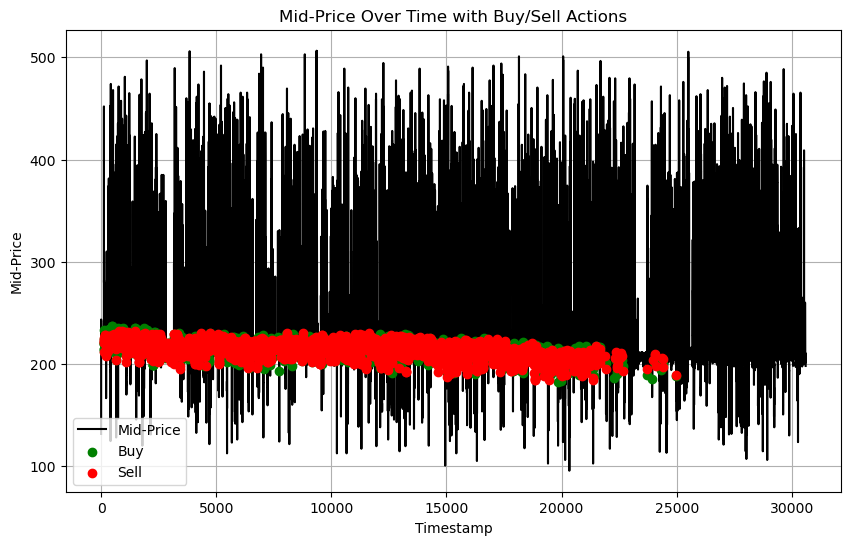

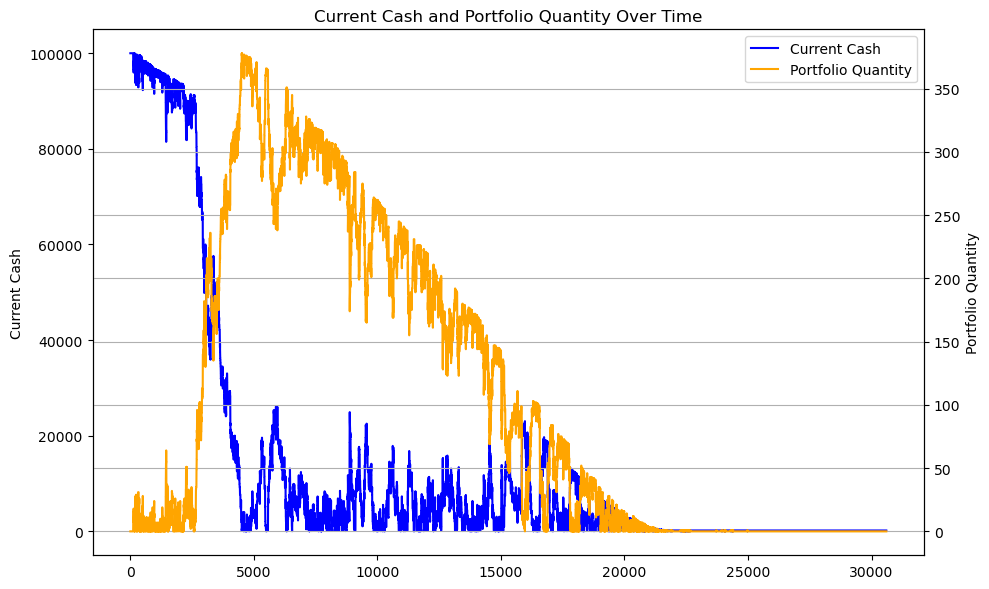

,Date,Timestamp,Mid-Price,Trade_Action,Trade_Price,Trade_Quantity,Current_Cash,Portfolio_Quantity
0,2025-05-06,1.984,131.5,hold,NaN,NaN,100000,0
1,2025-05-06,2.697,243.5,hold,NaN,NaN,100000,0
2,2025-05-06,2.759,243.0,hold,NaN,NaN,100000,0
3,2025-05-06,3.286,243.0,hold,NaN,NaN,100000,0
4,2025-05-06,3.596,242.5,hold,NaN,NaN,100000,0
...,...,...,...,...,...,...,...,...
322662,2025-05-06,30598.550,198.5,hold,NaN,NaN,186,0
322663,2025-05-06,30598.581,198.5,hold,NaN,NaN,186,0
322664,2025-05-06,30598.612,198.0,hold,NaN,NaN,186,0
322665,2025-05-06,30598.705,198.0,hold,NaN,NaN,186,0


In [10]:
xg_trades = xg_simulator.show_trades()
xg_trades

## Run Simulator for LSTM

In [5]:
# pip install torch

In [47]:
import torch
import torch.nn as nn

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BidirectionalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

lstm_model = torch.load('models/lstm_model.pth')
lstm_model.eval()

BidirectionalLSTM(
  (lstm): LSTM(3, 50, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [48]:
# Define a list of features to be used by the model for prediction
feature_columns = [
    "Timestamp",
    "Mid_Price_Raw",
    "Mid_Price_EMA_Short_z-score_normalised"
    ]

In [55]:
# Run simulation using the initial train XGBoost model
lstm_simulator = TradingSimulator(X_test, lstm_model, simple_trading_strategy, initial_cash=100000, split_limit=20, feature_columns=feature_columns, prediction_type='lstm')
lstm_trades = lstm_simulator.run_simulation()
lstm_trades

[['2025-05-06',
  1.984,
  131.5,
  'hold',
  None,
  None,
  100000,
  0,
  4.7929887771606445,
  -2.04678512262229],
 ['2025-05-06',
  2.697,
  243.5,
  'hold',
  None,
  None,
  100000,
  0,
  4.5217461585998535,
  -1.4853543697188036],
 ['2025-05-06',
  2.759,
  243.0,
  'hold',
  None,
  None,
  100000,
  0,
  4.4384989738464355,
  -1.0286222856701475],
 ['2025-05-06',
  3.286,
  243.0,
  'hold',
  None,
  None,
  100000,
  0,
  4.3944525718688965,
  -0.6549323987212472],
 ['2025-05-06',
  3.596,
  242.5,
  'hold',
  None,
  None,
  100000,
  0,
  4.370070457458496,
  -0.3518064777263428],
 ['2025-05-06',
  3.72,
  242.0,
  'hold',
  None,
  None,
  100000,
  0,
  4.355882167816162,
  -0.10641471069379942],
 ['2025-05-06',
  3.875,
  242.5,
  'hold',
  None,
  None,
  100000,
  0,
  4.347017765045166,
  0.09698072156884188],
 ['2025-05-06',
  3.937,
  242.5,
  'hold',
  None,
  None,
  100000,
  0,
  4.341615200042725,
  0.26339516614736647],
 ['2025-05-06',
  4.03,
  243.0,
  'ho

In [56]:
# Get performance metrics from the XGBoost Trial simulation
lstm_performance_metrics = lstm_simulator.get_performance_metrics()
print(lstm_performance_metrics)

(98460, 0)


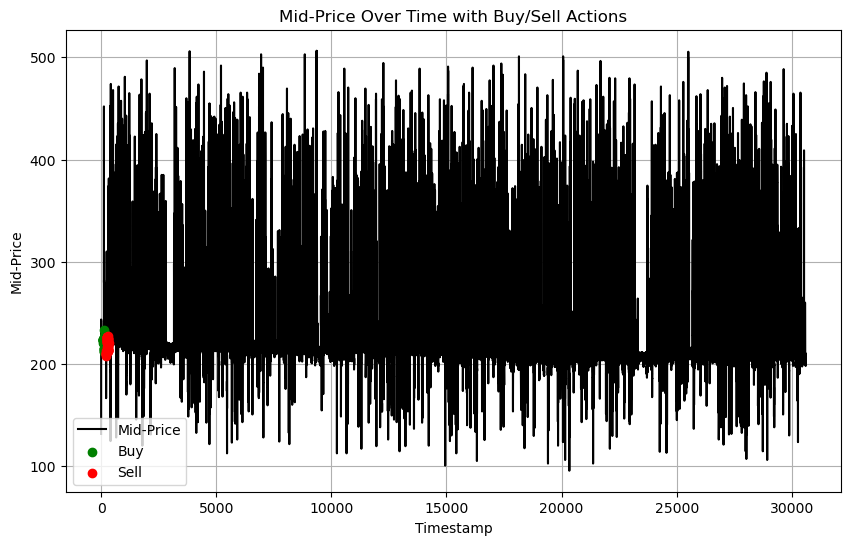

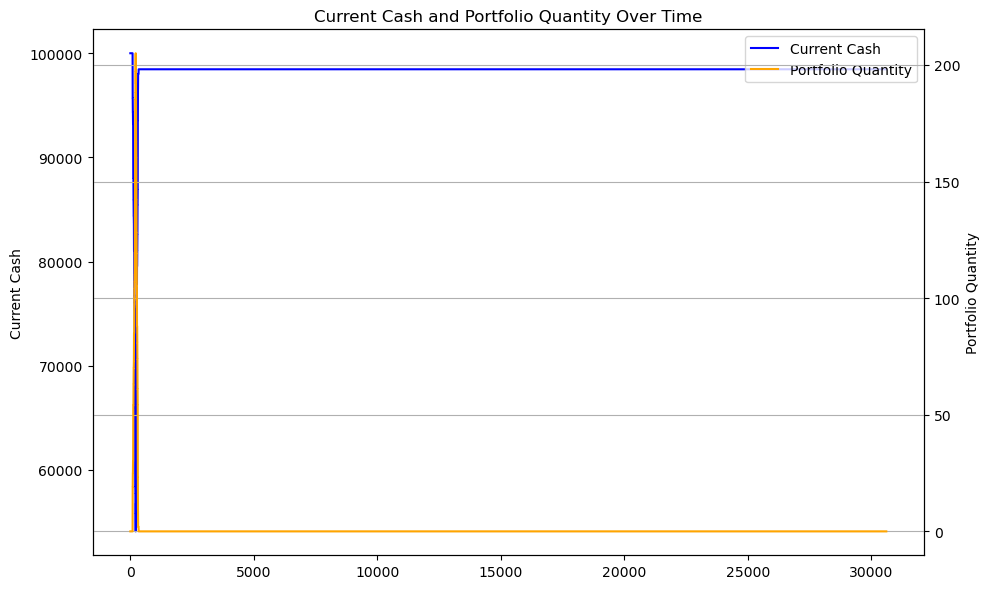

,Date,Timestamp,Mid-Price,Trade_Action,Trade_Price,Trade_Quantity,Current_Cash,Portfolio_Quantity,Prediction,Current_Val
0,2025-05-06,1.984,131.5,hold,NaN,NaN,100000,0,4.792989,-2.046785
1,2025-05-06,2.697,243.5,hold,NaN,NaN,100000,0,4.521746,-1.485354
2,2025-05-06,2.759,243.0,hold,NaN,NaN,100000,0,4.438499,-1.028622
3,2025-05-06,3.286,243.0,hold,NaN,NaN,100000,0,4.394453,-0.654932
4,2025-05-06,3.596,242.5,hold,NaN,NaN,100000,0,4.370070,-0.351806
...,...,...,...,...,...,...,...,...,...,...
322677,2025-05-06,30599.387,207.0,hold,NaN,NaN,98460,0,-4.068161,-0.079843
322678,2025-05-06,30599.480,207.0,hold,NaN,NaN,98460,0,-4.068349,-0.067323
322679,2025-05-06,30599.542,207.5,hold,NaN,NaN,98460,0,-4.074036,-0.054460
322680,2025-05-06,30599.635,208.0,hold,NaN,NaN,98460,0,-4.078973,-0.041315


In [57]:
lstm_trades = lstm_simulator.show_trades()
lstm_trades

## Compare Model Performance

In [37]:
# xgboost performance metrics
xg_final_cash = xg_performance_metrics[0]
# Counting the occurrences of "sell" in the Trade_Action column
xg_buy_count = (xg_trades['Trade_Action'] == 'buy').sum()
# Counting the occurrences of "sell" in the Trade_Action column
xg_sell_count = (xg_trades['Trade_Action'] == 'sell').sum()

# lstm performance metrics
lstm_final_cash = lstm_performance_metrics[0]
# Counting the occurrences of "sell" in the Trade_Action column
lstm_buy_count = (lstm_trades['Trade_Action'] == 'buy').sum()
# Counting the occurrences of "sell" in the Trade_Action column
lstm_sell_count = (lstm_trades['Trade_Action'] == 'sell').sum()

model_test = ['XGBoost', 'LSTM']
final_cash = [xg_final_cash, lstm_final_cash]
buy_trades = [xg_buy_count, lstm_buy_count]
sell_trades =[xg_sell_count, lstm_sell_count] 

results = {
    'Model' : model_test,
    'Final Cash' : final_cash,
    'Buy Trades' : buy_trades,
    'Sell Trades' : sell_trades
}

results_df = pd.DataFrame(results)
results_df

NameError: name 'xg_performance_metrics' is not defined

## Things To Note

- How do we deal with the fact that every order we make will impact the data and therefore we need to remove the bids/asks from the historical data when they are taken by the trade. The issue with the current implementation of the trading simulator is that when the Market order is applied the corresponding bid/ask remains in the dataset.
    - To combat this I have only allowed the model to make a single trade with a corresponding bid/ask this allows the simulator to act as a paper trading simulation where the trades made have no impact on the data, however it limits the model to make the trade only once rather than repeating the trade because the limit order is not updated.
- To run the simulator the relevant feature columns will need to be defined and the new model imported. Before running the model check the value being predicted is the same value as that defined in "current_mid_price" but shifted by the defined horizon.